# Audio Similarity Search
This notebook seeks to leverage appropriate machine learning techniques to enable similarity search with audio files. The end goal is an effective audio similarity search algorithm that can return similar audio to a user selected file. After reviewing the research, the following approach is attempted:
* Data Sourcing:
    * ~760 audio files (98MB on disk) were sourced from a collection of musical instrument samples collected over time, either from commercial libraries or [Freesound](http://freesound.org).
    * The audio-data folder should be placed in the root directory alongside this .ipynb Jupyter notebook file, and can be downloaded here: [https://drive.google.com/file/d/1RnQkkrvUNa-eWl3yDFaYKnV1lJU8fSjv/view?usp=sharing](https://drive.google.com/file/d/1RnQkkrvUNa-eWl3yDFaYKnV1lJU8fSjv/view?usp=sharing)
    * This is a somewhat restricted use case, however enough to demonstrate the success/failure of the approach with respect to audio-based similarity search.
    * Audio has been standardized to 22,050Hz sample rate, 16-bit depth, .wav files in order to save disk space, however the ingestion process is capable of handling many audio file types and any sample rate and bit-depth, and itself loads audio at a fixed sample rate.
* Data Ingestion:
    * Locating and loading Audio files: Up to the first 2 seconds of each audio file is loaded
        * This is a simplifying step that would be trivial to change or add sophisitcation around which 2 section of audio should be loaded (eg; the middle 2 seconds, etc.)
    * Mel Spectrogram image generation for each loaded audio file via [librosa](https://librosa.org/), with algorithm hop-size set to spread the spectrogram for the given audio length across the entire image size.
    * Image Normalization (value normalization)
* Images are fed into a novel Convolutional Autoencoder model in order to train an Encoder to encode the mel spectrogram features into compressed yet meaningful feature vectors.
* The trained Encoder from the Convolutional Autoencoder can then be employed to enable audio to be searched, wherein the encoded embeddings (feature vectors) are used directly in a simple Cosine Similarity search.
* It may be possible to achieve even better image reconstruction with transfer learning, wherein something like a pre-trained network (eg; VGG-19) could be leveraged and fine-tuned for this purpose.
* More sophisticated search algorithms, possibly coupled with further dimensionality reduction, may lead to further useful results.

## Setup

In [3]:
# Python built-ins
import time
import os
import random

# math/vector maniuplation and plots
import numpy as np
import matplotlib.pyplot as plt

# image saving
from skimage import io

# audio processing library
import librosa
import librosa.display

# audio playback in notebook
import IPython.display as ipd

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

## Global Variables

In [5]:
max_audio_duration = 2 # seconds
audio_samplerate = 22050 # Hz
n_fft = 4096 # number of ffts per window
fmin = 20 # min frequency to consider in mel cepstral coeffs
fmax = audio_samplerate // 2 # max frequency to consider in mel cepstral coeffs
input_image_size = (256, 256) # (width, height) pixels
image_value_type = np.uint16 # bit-depth of image, 16-bit seems to provide the best results
image_max_value = np.iinfo(image_value_type).max # used in scaling values 0-1
test_set_size = 0.2 # % of dataset to reserve for test set
trained_encoder_location = 'trained_encoders/ConvEncoder'
training_clip_paths = ['Drums', 'Bass', 'Keys']
inference_clip_paths = ['Drums', 'Bass', 'Keys']

## Helper Methods

In [8]:
def get_clip_paths(rel_paths):
    """
    Returns a list of full paths for all audio supported files under each path in rel_paths.
    """
    clip_paths = []
    for rel_path in rel_paths:
        audio_wav_dir = f'audio-data/{rel_path}'
        for root, dirs, files in os.walk(audio_wav_dir):
            for file in files:
                path = os.path.join(root, file)
                if path.endswith('.wav'):
                    clip_paths.append(path)
    return clip_paths

In [9]:
def get_audio_samples(path, min_samples):
    """
    Returns list of samples for an audio file at path,
    """
    y, _ = librosa.load(path=path, mono=True, sr=audio_samplerate, offset = 0, duration = max_audio_duration)
    # check if needs padding, up to n_fft used in mel calcs
    if len(y) < min_samples:
        padding = min_samples - len(y)
        y = np.pad(y, (0, min_samples - len(y)), 'constant')
    return y

In [10]:
def scale_minmax(X, max=image_max_value):
    """
    Normalizes values in range 0 - max.
    """
    X_min = X.min()
    X_max = X.max()
    X_diff = X_max - X_min
    return ((X - X_min)/X_diff) * max

def get_mel_spectrogram(y, sr, filename, save_file=False):
    """
    Returns mel spectrogram image data given audio data.
    """
    S = librosa.feature.melspectrogram(y=y,
                                       sr=sr,
                                       n_mels=input_image_size[1],
                                       n_fft=n_fft, 
                                       hop_length=max(int(len(y)/input_image_size[0]), 1),
                                       fmin = fmin,
                                       fmax = fmax)

    # convert to power-scale (decibels)
    img = librosa.power_to_db(S, ref=np.max).astype(np.float32)
    
    # discard extra mfcc columns, pad missing
    if img.shape[1] > input_image_size[0]:
        img = img[:, :input_image_size[0]]
    elif img.shape[1] < input_image_size[0]:
        img = np.pad(img, [(0,0), (0,input_image_size[0] - img.shape[1])], 'constant')
    
    # scale mel values to image values
    img = scale_minmax(img)
    
    # put low frequencies at the bottom in image (typical human readable format)
    img = np.flip(img, axis=0)
    
    img = img.astype(image_value_type)
    
    # save as PNG
    if save_file:
        print(f'Saving PNG: {filename}')
        io.imsave(filename.replace(".wav", ".png"), img)

    return img

## Data Ingestion and Preprocessing

In [11]:
def get_data(paths, save_images=False):
    """
    Get data from paths, prepared for training from. Optionally save Mel Spectrogram image files.
    """
    audio_paths = get_clip_paths(paths)
    mels = []
    paths = []
    for path in audio_paths:
        paths.append(path)
        samples = get_audio_samples(path, n_fft)
        mel = get_mel_spectrogram(samples, audio_samplerate, path, save_file=save_images)
        # we add a color channel, as the model will expect this in the input shape, and append to dataset
        mels.append(mel.reshape(input_image_size[1], input_image_size[0], 1))

    # Scale values to 0-1
    X = np.array(mels)
    X = X / float(image_max_value)
    return paths, X

## Mel Spectrogram Examples
Each image below is a Mel Spectrogram depicting an audio file. In these images, frequencies are represented on a log scale on the Y axis (lower frequencies on the bottom, higher frequencies on the top), across time on the X axis (scaled to the duration of audio imported, up to 2 seconds).

<table><tr>
    <td><img src="example_imgs/spect1.png") width="256" height="256"/> </td>
    <td><img src="example_imgs/spect2.png") width="256" height="256"/> </td>
    <td><img src="example_imgs/spect3.png") width="256" height="256"/> </td>
    <td><img src="example_imgs/spect4.png") width="256" height="256"/> </td>
</tr></table>

## Train Test Split

In [13]:
Y, X = get_data(training_clip_paths, save_images=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_set_size, random_state=42)
X_train = np.reshape(X_train, (len(X_train), input_image_size[0], input_image_size[1], 1))
X_test = np.reshape(X_test, (len(X_test), input_image_size[0], input_image_size[1], 1))

## Build Convolutional Autoencoder
The convolutional autoencoder below is built using the Keras functional API. It consists of a relatively simple Encoder and Decoder made of convolution and deconvolution (upsampling) layers. As configured, the Encoder creates an embedding with shape (16,16,16) which represents 75% memory compression from the input space. The Decoder simply reconstructs the input from the encoded embedding. The model uses Adam optimization and MSE loss.

Many architectures were tested, adjusting the number of filters, kernel size, and activation type, as well as number of layers (how far the compression could go and still be useful). The addition of a Dense (fully connected) layer was also tested at the 'bottom' of the Encoder, as seen in a number of examples in the research. However, this seemed to make training loss far higher, so the inclusion of this layer was quickly abandoned.

In [21]:
input_img = layers.Input(shape=(input_image_size[0],input_image_size[1], 1))

# Encoder
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# encoded.shape = (16,16,16)
# ~94% value compression (16*16*16)/(256*256)
# ~75% memory compression (16*16*16*4 bytes)/(256*256*1 bytes)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x) # no activation

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)       

## Train Autoencoder
This model trains relatively quickly, even on CPU. The model is set to train for only 10 epochs, however, it seems to converge rapidly and it is not clear that training further would yield signifcantly better results. Shuffle is set to True, which will shuffle the input dataset at the beginning of each epoch (this is a type of regularization).

Note that X_train is passed as x and y, given this is an autoencoder working with unlabeled data. The inputs are fed to the autoencoder, and the outputs of the autoencoder are compared to the inputs. Keras models also support passing in validation data (X_test in this case), which allows loss evaluation at the end of each epoch – the model is not trained on this data.

In [17]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
20/20 [==============================] - 216s 11s/step - loss: 0.0654 - val_loss: 0.0185
Epoch 2/10
20/20 [==============================] - 289s 14s/step - loss: 0.0155 - val_loss: 0.0098
Epoch 3/10
20/20 [==============================] - 287s 14s/step - loss: 0.0089 - val_loss: 0.0079
Epoch 4/10
20/20 [==============================] - 312s 16s/step - loss: 0.0071 - val_loss: 0.0065
Epoch 5/10
20/20 [==============================] - 332s 17s/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/10
20/20 [==============================] - 307s 15s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 7/10
20/20 [==============================] - 329s 16s/step - loss: 0.0051 - val_loss: 0.0052
Epoch 8/10
20/20 [==============================] - 286s 14s/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/10
20/20 [==============================] - 298s 15s/step - loss: 0.0048 - val_loss: 0.0049
Epoch 10/10
20/20 [==============================] - 313s 16s/step - loss: 0.0047 - val_loss: 0.0051

## Evaluate Autoencoder
Once trained, we can visually inspect the results of this autoencoder by comparing input images to reconstructed output images. We also visualize the input embeddings, and although the embedding itself is not 2-dimensional, some sense of what how the embedding represents the input can be ascertained. The reconstructed images reveal the lossy compression of the input embeddings, readily seen in the 'fuzziness' or 'blurriness' of the reconstruction with respect to the original input images. However, the features of the input images have been reconstructed in the output, meaning the input embeddings capture these features quite well.

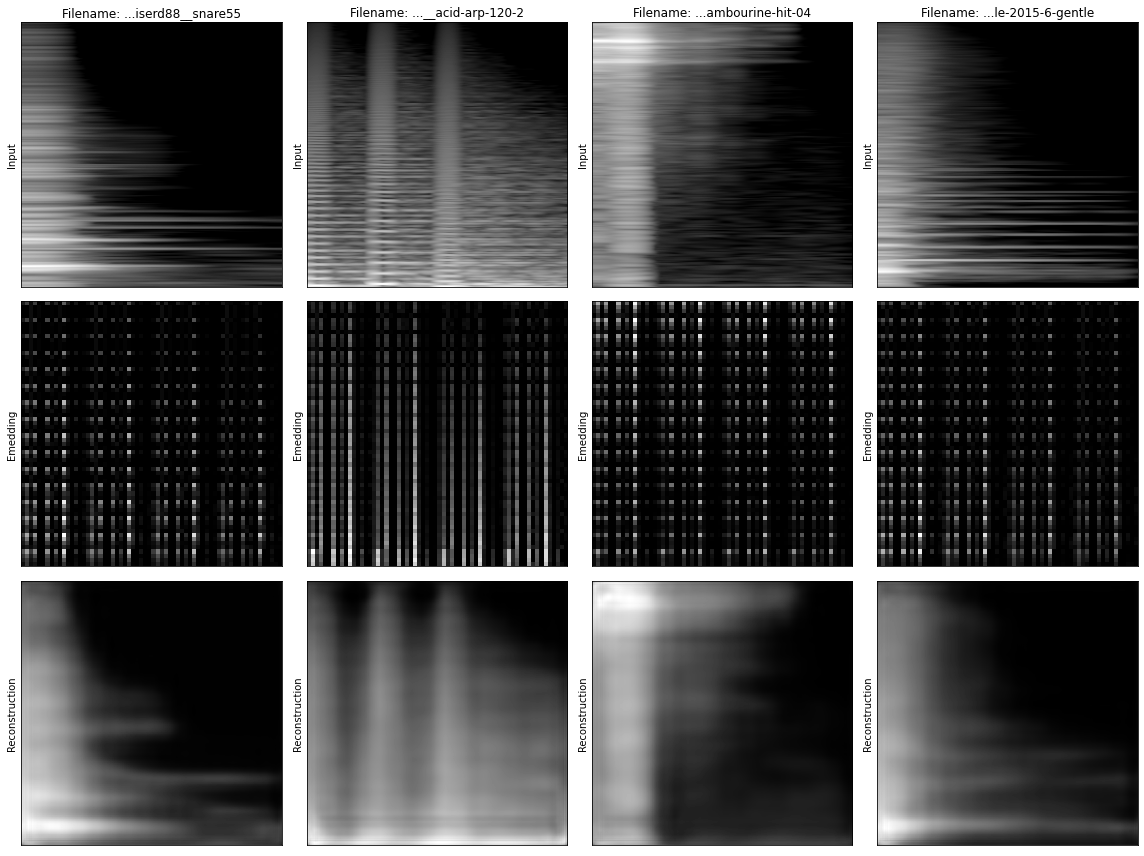

In [18]:
n = 4
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test[:n+1])
decoded_imgs = autoencoder.predict(X_test[:n+1])
plt.figure(figsize=(16, 12))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test[i].reshape(input_image_size[1], input_image_size[0]),  aspect='auto')
    plt.gray()
    plt.xticks([])  
    plt.yticks([])  
    ax.set_title(f'Filename: ...{Y_test[i][-20:-4]}')
    ax.set_ylabel('Input')

    # Display Embeddings
    ax = plt.subplot(3, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(64,64), aspect='auto')
    plt.gray()
    plt.xticks([])  
    plt.yticks([]) 
    ax.set_ylabel('Emedding')
    
    # Display reconstruction
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs[i].reshape(input_image_size[1], input_image_size[0]), aspect='auto')
    plt.gray()
    plt.xticks([])  
    plt.yticks([]) 
    ax.set_ylabel('Reconstruction')
    
plt.tight_layout()
plt.show()

## View PCA projection of Test Set Encoder Representations
PCA (Princpal Component Analysis) projection can give a sense of the embedding space and how the embeddings map with respect to each other. Below, this is visualized with 2 components (2 dimensions). The use of the PCA projection (using 3-9 components) of embeddings was tested in similarity search (taking cosine similarity of the PCA projection), but this seemed to perform more poorly than simply using the cosine similarity of the embeddings directly.

[0.56926126 0.15019263]


<function matplotlib.pyplot.show(close=None, block=None)>

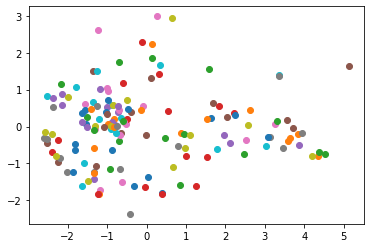

In [19]:
num_components = 2
encoded_imgs = encoder.predict(X_test)
embeddings = [np.ravel(e) for e in encoded_imgs]
pca = PCA(n_components=num_components)
pca.fit(embeddings)
pca_proj = pca.transform(embeddings)
print(pca.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot()
for pca in pca_proj:
    ax.scatter(pca[0], pca[1])
plt.show

## Save Trained Encoder Model
This step isolated the trained encoder and saves the model to be used separately.

In [20]:
model = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[8].output)
model.summary
model.save(trained_encoder_location)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-10-07 13:36:02.532710: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_encoders/ConvEncoder/assets


## Test Loading Saved Encoder and Create Embeddings
This simply tests loadig the Encoder model and creating and visualizing embeddings for test data.

In [ ]:
# Load the encoder and time inference on the first n inputs from X_test 
n = 10
encoder = keras.models.load_model(trained_encoder_location)
%timeit encoded_imgs = encoder.predict(X_test[:n])

plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((64, 64)))
    plt.gray()
    ax.set_title(Y_test[i][-16:-4])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## K-Means Clustering
K-means clustering was intended to be used as a part of the similarity search, however, it appears that the varying cluster density and spread makes this challenging. Perhaps a much larger dataset would make this less of an issue, however this approach was abandoned in favor of using the embeddings directly with a Cosine Similarity matrix, as seen below.

In [ ]:
clusters = [4, 8, 16, 32]
scores = []
embeddings = [np.ravel(e) for e in encoded_imgs]
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    print(f'k: {k}, silhouette score: {score}')
    scores.append(score)
k = clusters[np.argmax(scores)]
print(f'Optimal k: {k}')
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)

## Inference Using Encoder, Similarity Database Searching
Below the Encoder is loaded and used to create embeddings on the entire audio dataset. A Cosine Similarity matrix  is then created directly from the embeddings and cached in a 'similarity database' dictionary keyed by audio file path. The _get_similar_audio_ method can then directly retrieve the _n_results_ most similar audio files from the database based on the highest similarity values for a given audio file.

In [12]:
# load model and get audio data
start = time.time()
encoder = keras.models.load_model(trained_encoder_location)
all_paths, data = get_data(inference_clip_paths)
data = np.reshape(data, (len(data), input_image_size[0], input_image_size[1], 1))

In [14]:
# get encodings and and create similarity (cosine) database
start = time.time()

# create embeddings for all input data
encoded_data = encoder.predict(data) 

encoding_time = round(time.time()-start, 2)
print(f'encoding time: {encoding_time:.2f}s, {encoding_time/len(data):.3f}s per audio file.')

encoded_data = [np.ravel(e) for e in encoded_data]
similarity_matrix = cosine_similarity(encoded_data)

encoding time: 17.87s, 0.023s per audio file.


In [15]:
# create similarity database
similarity_database = {}
for P, S in zip(all_paths, similarity_matrix):
    similarity_database[P] = S

In [16]:
def get_similar_audio(path, similarity_database, n_results):
    """
    Retrieve n_results most similar audio files to the given audio file at path from the given similarity_database
    """
    n_results += 1
    all_paths = list(similarity_database.keys())
    ipd.display(ipd.Audio(path))
    # get similarity results for this audio
    similar = similarity_database[path]
    # get indexes of n_results highest values
    result_indexes = np.argpartition(similar, -n_results)[-n_results:]
    # build dictionary from results of paths and similarity scores
    results = {k:v for (k,v) in zip([all_paths[x] for x in result_indexes], [similar[x] for x in result_indexes])}
    # eliminate self from results
    results = {k:v for k, v in results.items() if k != path}
    # get keys for results by value in reverse sorted order
    sorted_keys = sorted(results, key=results.__getitem__, reverse=True)
    
    #show results
    count = 1
    for k in sorted_keys:
        print(f'Result {count}: {k}, Similarity: {results[k]:.3f}')
        ipd.display(ipd.Audio(k))
        count += 1

## Testing Similarity Search
Below the results from similarity search are demonstrated. For _n_examples_ we select a random audio file from the database and return the _n_results_ most similar audio files. Using the inline audio players, one can audition the original audio file and the returned results. Running this cell multiple times will produce new examples each time.

In [17]:
# test returning results and check playback
n_examples = 5
n_results = 4
for i in range(n_examples):
    path = all_paths[random.randint(0, len(all_paths))] # select a random path from all_paths
    print(f'Finding similar sounds to {path}')
    get_similar_audio(path, similarity_database, n_results)
    print('\n\n-----------------------------------------------------------\n\n')

Finding similar sounds to audio-data/Drums/212235__alexthegr81__tapesnare-6.wav


Result 1: audio-data/Drums/12521__johnlancia__sk1-sd.wav, Similarity: 0.984


Result 2: audio-data/Drums/12522__johnlancia__sk1-sd2.wav, Similarity: 0.984


Result 3: audio-data/Drums/269753__theriavirra__01a-hat-openclose-cymbals-snares.wav, Similarity: 0.970


Result 4: audio-data/Drums/269785__theriavirra__05b-hat-openclose-cymbals-snares.wav, Similarity: 0.970




-----------------------------------------------------------


Finding similar sounds to audio-data/Drums/270133__theriavirra__02-hat-pedal-cymbals-snares.wav


Result 1: audio-data/Drums/270054__theriavirra__02b-hat-pedal-cymbals-snares.wav, Similarity: 0.997


Result 2: audio-data/Drums/269947__theriavirra__03c-hat-pedal-cymbals-snares.wav, Similarity: 0.996


Result 3: audio-data/Drums/269936__theriavirra__07-hat-pedal-cymbals-snares.wav, Similarity: 0.995


Result 4: audio-data/Drums/269773__theriavirra__01a-hat-thin-cymbals-snares.wav, Similarity: 0.992




-----------------------------------------------------------


Finding similar sounds to audio-data/Drums/319872__theriavirra__drumsticks-pro-mark-l-a-special-5bn-hickory-no8.wav


Result 1: audio-data/Drums/319869__theriavirra__drumsticks-pro-mark-l-a-special-5bn-hickory-no5.wav, Similarity: 0.987


Result 2: audio-data/Drums/319894__theriavirra__drumsticks-lutner-2bn-hickory-no3.wav, Similarity: 0.985


Result 3: audio-data/Drums/319893__theriavirra__drumsticks-lutner-2bn-hickory-no4.wav, Similarity: 0.984


Result 4: audio-data/Drums/319876__theriavirra__drumsticks-pro-mark-l-a-special-5bn-hickory-no4.wav, Similarity: 0.983




-----------------------------------------------------------


Finding similar sounds to audio-data/Drums/270049__theriavirra__07a-ride-long-cymbals-snares.wav


Result 1: audio-data/Drums/269937__theriavirra__07-ride-long-cymbals-snares.wav, Similarity: 0.997


Result 2: audio-data/Drums/269928__theriavirra__03-ride-long-cymbals-snares.wav, Similarity: 0.992


Result 3: audio-data/Drums/269926__theriavirra__03a-ride-long-cymbals-snares.wav, Similarity: 0.991


Result 4: audio-data/Drums/269968__theriavirra__01-ride-silent-cymbals-snares.wav, Similarity: 0.990




-----------------------------------------------------------


Finding similar sounds to audio-data/Drums/320278__vihaleipa__hand-clap-05.wav


Result 1: audio-data/Drums/320272__vihaleipa__hand-clap-03.wav, Similarity: 0.996


Result 2: audio-data/Drums/320274__vihaleipa__hand-clap-01.wav, Similarity: 0.996


Result 3: audio-data/Drums/320273__vihaleipa__hand-clap-02.wav, Similarity: 0.995


Result 4: audio-data/Drums/320271__vihaleipa__hand-clap-04.wav, Similarity: 0.993




-----------------------------------------------------------




## Results
The results demonstrated above seem quite good. The resulting Encoder model and similarity search based on a Cosine Similarity matrix would be imminently useful in the context of an audio sample browser or audio production application, where producers frequently have the need to quickly find similar audio to a given sample. There are, however, a few results returned which do not match the searched audio very well.

A more sophisticated approach, taking into account multiple discrete aspects of auditory perception (using different audio features with more models in an ensemble approach) may lead to more robust results. Further research points to possibly using a Convolutional LSTM model that could take into account the relationship of frequency over time, although the above simpler Convolutional approach does seem to capture a sense of time given the input images x-axis (width) does, in fact, represent time. Simpler features could be accounted for relatively easily, as well, such as RMS loudness, average pitch class (key centers vs atonal), and much more.

This was a very interesting project, and I look forward to continuing research in this direction.